# Image Colorization

1. Adopt the implementation of the U-Net network from the previous task and train it on the task of image colorization.
2. Remove the skip connections of the implemented U-Net network, retrain it on the colorization task and examine the difference.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content
!unzip -q /content/drive/MyDrive/landscapes -d /content/data

Mounted at /content/drive
/content


In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from typing import Type

In [20]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, shortcut=True):
        super(UNet, self).__init__()
        # define the neural network blocks for UNet
        # The implementation details of the network are listed in the paper: https://arxiv.org/pdf/1505.04597.pdf
        #num_classes = 13

        # Encoder
        self.shortcut = shortcut
        self.e11 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        if self.shortcut:
            self.d11 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        else:
            self.d11 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        if self.shortcut:
            self.d21 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        else:
            self.d21 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        if self.shortcut:
            self.d31 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        else:
            self.d31 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        if self.shortcut:
            self.d41 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        else:
            self.d41 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # Output
        self.outconv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        #encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder

        if self.shortcut:
            xu1 = self.upconv1(xe52)
            xu11 = torch.cat([xu1, xe42], dim=1)
            xd11 = relu(self.d11(xu11))
            xd12 = relu(self.d12(xd11))

            xu2 = self.upconv2(xd12)
            xu22 = torch.cat([xu2, xe32], dim=1)
            xd21 = relu(self.d21(xu22))
            xd22 = relu(self.d22(xd21))

            xu3 = self.upconv3(xd22)
            xu33 = torch.cat([xu3, xe22], dim=1)
            xd31 = relu(self.d31(xu33))
            xd32 = relu(self.d32(xd31))

            xu4 = self.upconv4(xd32)
            xu44 = torch.cat([xu4, xe12], dim=1)
            xd41 = relu(self.d41(xu44))
            xd42 = relu(self.d42(xd41))
            out = self.outconv(xd42)

        else:
            xd1 = relu(self.d11(self.upconv1(xe52)))
            xd1 = relu(self.d12(xd1))

            xd2 = relu(self.d21(self.upconv2(xd1)))
            xd2 = relu(self.d22(xd2))

            xd3 = relu(self.d31(self.upconv3(xd2)))
            xd3 = relu(self.d32(xd3))

            xd4 = relu(self.d41(self.upconv4(xd3)))
            xd4 = relu(self.d42(xd4))
            out = self.outconv(xd4)
        return out


## Download the dataset from google drive:

In [4]:
!pip install --upgrade --no-cache-dir gdown
#!gdown  --id 1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0
# use the other file id if the first one doesn't work
#!gdown  --id 1Q0UIc27o6qlFAqNiDKfM06KwpzHCGKLU
#!unzip -q landscapes.zip -d ./data

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


## Colorization dataset

The dataset class loads the image and also converts them to a grayscale version. The image pair is then used for training.

In [5]:
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import numpy as np

class ColorizationDataset(Dataset):

    def __init__(self, train=True):
        self.all_images = sorted(glob.glob("./data/*"))
        self.images = self.all_images[:-500]
        self.test_images = self.all_images[-500:]
        if not train:
          self.images = self.test_images

        self.resize_shape = (256, 256)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        gray_image = np.array(gray_image).reshape((image.shape[0], image.shape[1], 1)).astype(np.float32) / 255.0

        image = np.transpose(image, (2, 0, 1))
        gray_image = np.transpose(gray_image, (2, 0, 1))
        return image, gray_image

    def __getitem__(self, idx):
        image, gray_image = self.transform_image(self.images[idx])
        sample = {'image': image, "gray_image": gray_image, 'idx': idx}

        return sample

## Examples of the training image pairs

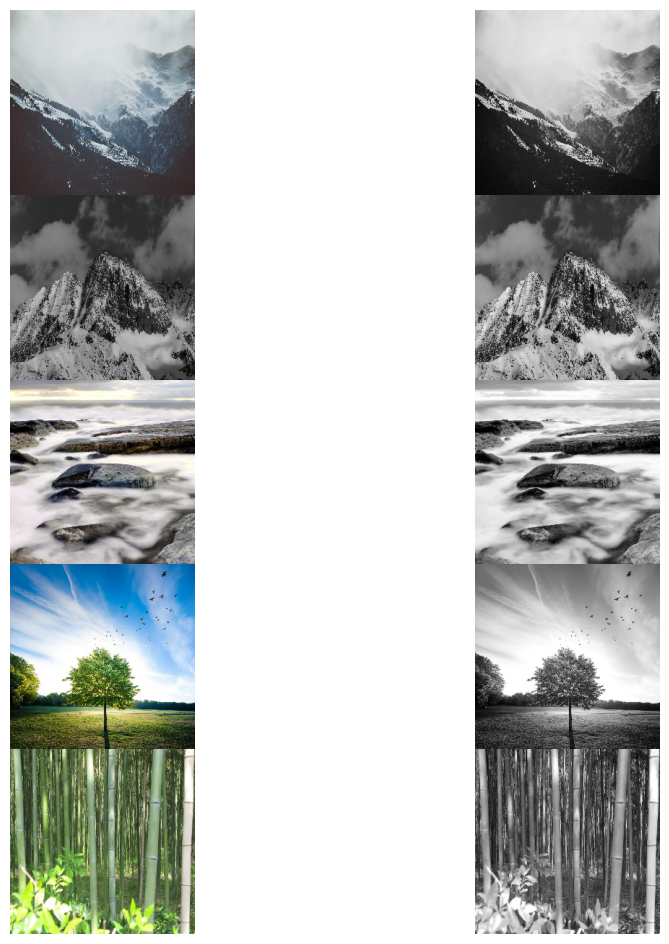

In [6]:
import matplotlib.pyplot as plt
trainset = ColorizationDataset(train=True)
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 5
for i in range(rows):
  batch = trainset[np.random.randint(len(trainset))]
  img = batch['image'].transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = batch['gray_image'][0,:,:]
  fig.add_subplot(rows, columns, i*columns+1)

  plt.imshow(img)
  fig.add_subplot(rows, columns, i*columns+2)

  plt.imshow(gray,cmap='gray')

plt.show()


## Training loop


In [23]:
import torch
from tqdm.notebook import tqdm


trainset = ColorizationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = ColorizationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


import torch.optim as optim

net = UNet(in_channels=1, out_channels=3, shortcut=True)
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epochs=10
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch)+"/"+str(epochs), unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs;
          gray_images = data["gray_image"]
          color_images = data["image"]

          # Get the inputs to the GPU
          gray_images = gray_images.cuda()
          color_images = color_images.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(gray_images)
          loss = nn.functional.l1_loss(outputs, color_images)
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
          prog_bar.update(4)


Epoch: 0/10:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 1/10:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 2/10:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 3/10:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 4/10:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 5/10:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 6/10:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 7/10:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 8/10:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 9/10:   0%|          | 0/3819 [00:00<?, ?img/s]

## Display output examples from the test set

In [25]:
net.eval()
fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
  batch = testset[i+80]
  img = batch['image']
  gray = batch['gray_image']
  img_tensor = torch.from_numpy(gray).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  outputs = net(img_tensor)
  out_image = outputs[0,:,:,:].detach().cpu().numpy().transpose((1,2,0))
  out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = gray[0,:,:]
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
  fig.add_subplot(rows, columns, i*columns+2)
  plt.imshow(out_image)
  fig.add_subplot(rows, columns, i*columns+3)
  plt.imshow(gray,cmap='gray')

plt.show()

Output hidden; open in https://colab.research.google.com to view.